# Creating Training Images from Labeled Planet GeoTiffs

This notebook contains code to create a directory of 256x256 image chips from fully labeled PlanetScope scenes. A separate directory is created for each image chip and contains two subdirectories:
  + `image` contains the image chip from the raw PlanetScope GeoTiff 
  + `mask` contains `n` binary GeoTiff mask files, where `n` is the number of objects in the image

In [1]:
from IPython.display import Image
import rasterio
import skimage
import os
import pathlib
import math
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from rasterio.plot import show
from osgeo import gdal

We'll start by loading and visualizing a fully labeled PlanetScope scene containing five bands (B,G,R,NIR,mask)

In [5]:
# Load PlanetScope 4-band analytic-sr image
filename = "../img/labeled_tiffs/20180410_020422_0f31_3B_AnalyticMS_SR_labels.tif"
# Save the image name for later filenaming use
image_name = '20180410_020422_0f31'
# Load image
image = rasterio.open(filename)

Plot the RGB image

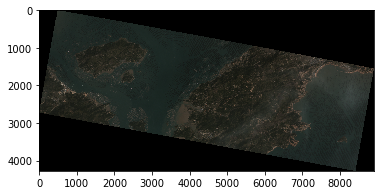

In [6]:
# Scale variable. Note bands of Planet imagery go BGR
image_rgb = exposure.rescale_intensity(image.read((3,2,1)), out_range='uint8')
# Plot image
show(image_rgb)

Plot the mask band

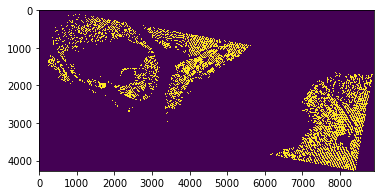

In [8]:
# Plot mask band
show(image.read(6)) # lines mask

### Image Chipping

Now let's write a function to chip all images in a directory and create the directories described above for each image chip and mask.

In [11]:
# Define a function to create image chips with masks of every GeoTiff file in a directory
def image_chips_masks(tiff_directory):
    
    # Get all GeoTiff filnames in specified directory
    files = np.array(os.listdir(tiff_directory))
    tiffs = pd.Series(files).str.contains('.tif')
    files = files[tiffs]
#     files = ['20180410_020422_0f31_3B_AnalyticMS_SR_labels.tif']
#     tiffs = pd.Series(files).str.contains('.tif')
 
    
    # Loop over files
    for filename in files:
        
        # Get image name to use for creating directory
        image_name = filename.split("_")[0:3]
        image_name = "%s_%s_%s" % (image_name[0], image_name[1], image_name[2])
        
        # Image directory and subdirectories
        image_dir = tiff_directory + image_name + '/'        
        
        # Print filenames
        print('filename: ' + filename + '\n' + 'image name: ' + image_name)
        
        # Make directories to store raw and rgb image chips
        pathlib.Path(image_dir).mkdir(parents=True, exist_ok=True)

        # Iterate over image blocks - which are 256x256 - and save new GeoTiffs
        with rasterio.open(tiff_directory + filename) as src:
            
            # Get block dimensions of src
            for ji, window in src.block_windows(1):
                
                # read B,G,R,NIR band
                r = src.read((1,2,3,4), window=window)
                
                # Skip image if missing data
                if 0 in r:
                    continue
           
                else:
                    
                    # Create chip id
                    chip_name = image_name + '_' + str(ji[0]) + '_' + str(ji[1])                    
                    
                    # Create directory for image chip and subdirectories for image and labels
                    chip_dir = image_dir + chip_name + '/'                    
                    img_dir = chip_dir + '/image/'
                    mask_dir = chip_dir + '/class_masks/'
                    
                    # list of directories to map over
                    dirs = [chip_dir, img_dir, mask_dir]
                    
                    # Make chip directory and subdirectories
                    for d in dirs:
                        pathlib.Path(d).mkdir(parents=True, exist_ok=True)
                    
                    # Open a new GeoTiff data file in which to save the image chip
                    with rasterio.open((img_dir + chip_name + '.tif'), 'w', driver='GTiff',
                               height=r.shape[1], width=r.shape[2], count=4,
                               dtype=rasterio.uint16, crs=src.crs, 
                               transform=src.transform) as new_img:
        
                        # Write the rescaled image to the new GeoTiff
                        new_img.write(r)
                
                """Load and save mask as separate tif file(s), one for each class"""
                # Count number of mask bands (bands - 4)
                masks = src.count - 4
                
                if masks < 2:
                    # read mask
                    m = src.read(5, window=window)
                    
                    # Open a new Tiff data file in which to save the image mask (use class 1 for now)                    
                    with rasterio.open((mask_dir + chip_name + '_1_mask.tif'), 'w', driver='GTiff',
                                       height=m.shape[0], width=m.shape[1], count=1,
                                       dtype=rasterio.uint16, crs=src.crs, 
                                       transform=src.transform) as new_img:
                        # Write the mask to the new GeoTiff            
                        new_img.write(m, 1)
                
                else:
                                        
                    for a in (1, masks):
                        
                        # Masks are rafts = 1 and lines = 2. Incorrectly labeled first time by
                        # using the loop index. Hardcoded to fix
                        if a == 1:
                            label = '2'
                        else:
                            label = '1'
                        
                        # read mask
                        m = src.read(4 + a, window=window)
                    
                        # Open a new Tiff data file in which to save the image mask. Label with class number                    
                        with rasterio.open((mask_dir + chip_name + '_' + str(a) + '_mask.tif'), 'w', driver='GTiff',
                                           height=m.shape[0], width=m.shape[1], count=1,
                                           dtype=rasterio.uint16, crs=src.crs, 
                                           transform=src.transform) as new_img:
                            # Write the mask to the new GeoTiff            
                            new_img.write(m, 1)
                        
                        if(a == 2): print('saving second mask')


# Run function                
image_chips_masks('../img/labeled_tiffs/')

filename: 20180409_014042_1015_3B_AnalyticMS_SR_labels.tif
image name: 20180409_014042_1015


/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/ipykernel/__main__.py:109: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


filename: 20180410_020422_0f31_3B_AnalyticMS_SR_labels.tif
image name: 20180410_020422_0f31
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second mask
saving second m